

## **Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ**

# Путешествие по Спрингфилду.


Сегодня вам предстоить помочь телекомпании FOX  в обработке их контента. Как вы знаете сериал Симсоны идет на телеэкранах более 25 лет и за это время скопилось очень много видео материала. Персоонажи менялись вместе с изменяющимися графическими технологиями   и Гомер 2018 не очень похож на Гомера 1989. Нашей задачей будет научиться классифицировать персонажей проживающих в Спрингфилде. Думаю, что нет смысла представлять каждого из них в отдельности.



 ![alt text](https://vignette.wikia.nocookie.net/simpsons/images/5/5a/Spider_fat_piglet.png/revision/latest/scale-to-width-down/640?cb=20111118140828)



### Установка зависимостей

In [ ]:
!pip install -U torch torchvision

Requirement already up-to-date: torch in /usr/local/lib/python3.7/dist-packages (1.8.1+cu101)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.7/dist-packages (0.9.1+cu101)


In [ ]:
# установка подходящей версии torch

from os.path import exists
# from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
# platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

ERROR: torch-0.4.1-{platform}-linux_x86_64.whl is not a valid wheel filename.


In [ ]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
# нам необходима версия pillow  5.3.0
# удалим старую версию и установим новую
!pip uninstall -y Pillow
!pip install Pillow==5.3.0
import PIL
print(PIL.PILLOW_VERSION)
# здесь должна быть версия 5.3.0. если это не так перехгрузите данный ноутбук:
# Menu > Runtime > Restart Runtime

Uninstalling Pillow-5.3.0:
  Successfully uninstalled Pillow-5.3.0
  Using cached https://files.pythonhosted.org/packages/62/8c/230204b8e968f6db00c765624f51cfd1ecb6aea57b25ba00b240ee3fb0bd/Pillow-5.3.0-cp37-cp37m-manylinux1_x86_64.whl
ERROR: bokeh 2.3.1 has requirement pillow>=7.1.0, but you'll have pillow 5.3.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


5.3.0


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!ls -l /content/gdrive/MyDrive/journey-springfield.zip

-rw------- 1 root root 546224286 Apr 22 08:09 /content/gdrive/MyDrive/journey-springfield.zip


In [ ]:
!unzip -q /content/gdrive/MyDrive/journey-springfield.zip

In [ ]:
!ls -1

characters_illustration.png
gdrive
label_encoder.pkl
sample_data
sample_submission.csv
testset
train


In [ ]:
from pathlib import Path
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

In [ ]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))
print(len(train_val_files)) #=> 20933
print(len(test_files)) #=> 991

20933
991


In [ ]:
!nvidia-smi
import torch
torch.cuda.is_available()

Sat Apr 24 08:18:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [ ]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [ ]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
if torch.cuda.is_available():
  DEVICE = torch.device("cuda")
else:
  DEVICE = torch.device("cpu")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [ ]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = {
                  'train': transforms.Compose([
                      # transforms.RandomResizedCrop(224),
                      transforms.Resize(size=(224,244)),
                      transforms.RandomHorizontalFlip(),
                      transforms.ToTensor(),
                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                  ]),
                  'val': transforms.Compose([
                      transforms.Resize(size=(224,244)),
                      # transforms.CenterCrop(224),
                      transforms.ToTensor(),
                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                  ]),
}
        x = self.load_sample(self.files[index])
        # x = self._prepare_sample(x)
        # x = np.array(x / 255, dtype='float32')
        if self.mode == 'train':
            x = transform['train'](x)
        else:
            x = transform['val'](x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    # def _prepare_sample(self, image):
    #     image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
    #     return np.array(image)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [ ]:
# uncomment if you have problem with pillow
def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
Image.register_extension = register_extension
def register_extensions(id, extensions): 
    for extension in extensions: register_extension(id, extension)
Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

NameError: ignored

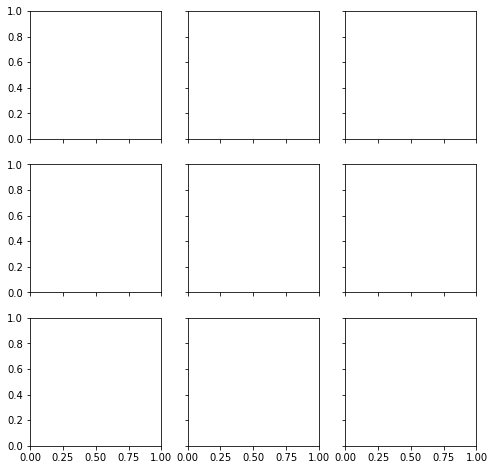

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

**Балансировка классов**

In [ ]:
def create_dct_from_labels(train_val_labels):
    """Функция создает из list train_val_labels, содержащего метки классов
    соответсвующим картинкам из выборки, словарь dict с ключами соответсвующими
    названиям классов, и значениями, соответвующими колчеству этих классов в 
    list train_val_labels"""
    dct_simpsons = {}
    for label_i in np.unique(train_val_labels).tolist():
        dct_simpsons.update({label_i:train_val_labels.count(label_i)})

    return dct_simpsons

In [ ]:
train_labels = [path.parent.name for path in train_files] # классы train
val_labels = [path.parent.name for path in val_files]     # классы val

In [ ]:
def create_dct_path_labels(train_files, train_labels):
    dct_simpsons = {}
    for label_i in np.unique(train_labels).tolist():
        dct_simpsons[label_i] = []

    for path_i, label_i in zip(train_files, train_labels):
        dct_simpsons[label_i].append(path_i)

    return dct_simpsons

def print_dct(dct_simpsons):
    for key in dct_simpsons:
        print(f"{key}\t{dct_simpsons[key]}")

In [ ]:
# Создадим словарь в котором ключами будут персонажи Симпсонов, а значениями списки с путями к картинкам.
dct_path_train = create_dct_path_labels(train_files, train_labels)

In [ ]:
# Посмотрим, что у нас получилось.
print_dct(dct_path_train)

abraham_grampa_simpson	[PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0721.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0606.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0742.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0091.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0000.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0109.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0449.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0175.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0258.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0149.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0133.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0294.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0821.jpg'), PosixPath('train/simpsons_d

In [ ]:
# Дополним картинки классов у которых менее 100 картинок, до 100 картинок в классе
for person in dct_path_train:
    if len(dct_path_train[person]) < 100:
        dct_path_train[person] = dct_path_train[person] * (100 // len(dct_path_train[person]))
        dct_path_train[person].extend(dct_path_train[person][:100 - len(dct_path_train[person])])

In [ ]:
# Проверим что получилось 
for person in dct_path_train:
    print(f"{person}\t{len(dct_path_train[person])}")

abraham_grampa_simpson	685
agnes_skinner	100
apu_nahasapeemapetilon	467
barney_gumble	100
bart_simpson	1006
carl_carlson	100
charles_montgomery_burns	895
chief_wiggum	739
cletus_spuckler	100
comic_book_guy	352
disco_stu	100
edna_krabappel	343
fat_tony	100
gil	100
groundskeeper_willie	100
homer_simpson	1684
kent_brockman	373
krusty_the_clown	904
lenny_leonard	233
lionel_hutz	100
lisa_simpson	1015
maggie_simpson	100
marge_simpson	968
martin_prince	100
mayor_quimby	185
milhouse_van_houten	809
miss_hoover	100
moe_szyslak	1089
ned_flanders	1090
nelson_muntz	269
otto_mann	100
patty_bouvier	100
principal_skinner	895
professor_john_frink	100
rainier_wolfcastle	100
ralph_wiggum	100
selma_bouvier	100
sideshow_bob	658
sideshow_mel	100
snake_jailbird	100
troy_mcclure	100
waylon_smithers	136


In [ ]:
new_train_files = []

for person in dct_path_train:
    new_train_files.extend(dct_path_train[person])

new_train_label = [path.parent.name for path in new_train_files] # классы train

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')
new_train_dataset = SimpsonsDataset(new_train_files, mode='train')

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224 
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    for inputs, labels in tqdm(train_loader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(f, f1, model, epochs, batch_size):
    train_loader = DataLoader(new_train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(list(model.features.parameters())[-layers_to_unfreeze:] + 
                      list(model.classifier.parameters()), amsgrad=True, lr=1e-4)
        criterion = nn.CrossEntropyLoss()
        exp_lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=7)

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            exp_lr_scheduler.step(val_loss)
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
n_classes = len(np.unique(train_val_labels))

Запустим обучение сети.

VGG16_bn:

In [ ]:
from torchvision import models

In [ ]:
vgg16_bn_model = models.vgg16_bn(pretrained=True)
layers_to_unfreeze = 15
# замораживаем параметры (веса)
for param in vgg16_bn_model.features[:-layers_to_unfreeze].parameters():
    param.requires_grad = False

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 25088
# Заменяем Fully-Connected слой на наш линейный классификатор
vgg16_bn_model.classifier = nn.Linear(num_features, n_classes)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


In [ ]:
# посмотрим какие параметры нейросети мы учим
params_to_update = vgg16_bn_model.parameters()
print("Params to learn:")

params_to_update = []
for name,param in vgg16_bn_model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 features.30.weight
	 features.30.bias
	 features.31.weight
	 features.31.bias
	 features.34.weight
	 features.34.bias
	 features.35.weight
	 features.35.bias
	 features.37.weight
	 features.37.bias
	 features.38.weight
	 features.38.bias
	 features.40.weight
	 features.40.bias
	 features.41.weight
	 features.41.bias
	 classifier.weight
	 classifier.bias


In [ ]:
vgg16_bn_model.to(DEVICE)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
history_vgg16 = train(new_train_dataset, val_dataset, model=vgg16_bn_model, epochs=25, batch_size=128)


epoch:   0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  1%|          | 1/132 [00:01<04:05,  1.87s/it]

  2%|▏         | 2/132 [00:03<04:00,  1.85s/it]

  2%|▏         | 3/132 [00:05<03:55,  1.82s/it]

  3%|▎         | 4/132 [00:07<03:50,  1.80s/it]

  4%|▍         | 5/132 [00:08<03:47,  1.79s/it]

  5%|▍         | 6/132 [00:10<03:44,  1.78s/it]

  5%|▌         | 7/132 [00:12<03:41,  1.78s/it]

  6%|▌         | 8/132 [00:14<03:39,  1.77s/it]

  7%|▋         | 9/132 [00:15<03:35,  1.75s/it]

  8%|▊         | 10/132 [00:17<03:33,  1.75s/it]

  8%|▊         | 11/132 [00:19<03:33,  1.76s/it]

  9%|▉         | 12/132 [00:21<03:31,  1.77s/it]

 10%|▉         | 13/132 [00:23<03:31,  1.77s/it]

 11%|█         | 14/132 [00:24<03:28,  1.77s/it]

 11%|█▏        | 15/132 [00:26<03:25,  1.76s/it]

 12%|█▏        | 16/132 [00:28<03:24,  1.77s/it]

 13%|█▎        | 17/132 [00:30<03:22,  1.76s/it]

 14%|█▎        | 18/132 [00:31<03:20,  1.76s/it]

 14%|█▍        | 19/

loss 1.2798585186998814



epoch:   4%|▍         | 1/25 [04:59<1:59:49, 299.58s/it]

  0%|          | 0/132 [06:36<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]


Epoch 001 train_loss: 1.2799     val_loss 0.3968 train_acc 0.7064 val_acc 0.9094




  1%|          | 1/132 [00:01<03:54,  1.79s/it]

  2%|▏         | 2/132 [00:03<03:51,  1.78s/it]

  2%|▏         | 3/132 [00:05<03:47,  1.76s/it]

  3%|▎         | 4/132 [00:07<03:44,  1.75s/it]

  4%|▍         | 5/132 [00:08<03:42,  1.75s/it]

  5%|▍         | 6/132 [00:10<03:40,  1.75s/it]

  5%|▌         | 7/132 [00:12<03:39,  1.76s/it]

  6%|▌         | 8/132 [00:14<03:37,  1.75s/it]

  7%|▋         | 9/132 [00:15<03:36,  1.76s/it]

  8%|▊         | 10/132 [00:17<03:35,  1.77s/it]

  8%|▊         | 11/132 [00:19<03:31,  1.75s/it]

  9%|▉         | 12/132 [00:21<03:30,  1.76s/it]

 10%|▉         | 13/132 [00:22<03:29,  1.76s/it]

 11%|█         | 14/132 [00:24<03:29,  1.78s/it]

 11%|█▏        | 15/132 [00:26<03:27,  1.77s/it]

 12%|█▏        | 16/132 [00:28<03:24,  1.77s/it]

 13%|█▎        | 17/132 [00:29<03:21,  1.75s/it]

 14%|█▎        | 18/132 [00:31<03:19,  1.75s/it]

 14%|█▍        | 19/132 [00:33<03:17,  1.75s/it]

 15%|█▌        | 20/132 [00:35<03:15,  1.74s/it]

 16%|█▌

loss 0.2192347985368468



epoch:   8%|▊         | 2/25 [09:55<1:54:25, 298.50s/it]

  0%|          | 0/132 [11:32<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]


Epoch 002 train_loss: 0.2192     val_loss 0.2828 train_acc 0.9466 val_acc 0.9261




  1%|          | 1/132 [00:01<03:45,  1.72s/it]

  2%|▏         | 2/132 [00:03<03:43,  1.72s/it]

  2%|▏         | 3/132 [00:05<03:43,  1.73s/it]

  3%|▎         | 4/132 [00:06<03:42,  1.74s/it]

  4%|▍         | 5/132 [00:08<03:41,  1.74s/it]

  5%|▍         | 6/132 [00:10<03:40,  1.75s/it]

  5%|▌         | 7/132 [00:12<03:37,  1.74s/it]

  6%|▌         | 8/132 [00:13<03:33,  1.73s/it]

  7%|▋         | 9/132 [00:15<03:31,  1.72s/it]

  8%|▊         | 10/132 [00:17<03:30,  1.73s/it]

  8%|▊         | 11/132 [00:19<03:29,  1.73s/it]

  9%|▉         | 12/132 [00:20<03:27,  1.73s/it]

 10%|▉         | 13/132 [00:22<03:24,  1.72s/it]

 11%|█         | 14/132 [00:24<03:24,  1.73s/it]

 11%|█▏        | 15/132 [00:25<03:23,  1.74s/it]

 12%|█▏        | 16/132 [00:27<03:24,  1.76s/it]

 13%|█▎        | 17/132 [00:29<03:20,  1.74s/it]

 14%|█▎        | 18/132 [00:31<03:18,  1.74s/it]

 14%|█▍        | 19/132 [00:32<03:16,  1.74s/it]

 15%|█▌        | 20/132 [00:34<03:15,  1.74s/it]

 16%|█▌

loss 0.09296842333691188



epoch:  12%|█▏        | 3/25 [14:48<1:48:53, 296.97s/it]

  0%|          | 0/132 [16:26<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]


Epoch 003 train_loss: 0.0930     val_loss 0.2458 train_acc 0.9782 val_acc 0.9389




  1%|          | 1/132 [00:01<03:40,  1.68s/it]

  2%|▏         | 2/132 [00:03<03:41,  1.70s/it]

  2%|▏         | 3/132 [00:05<03:40,  1.71s/it]

  3%|▎         | 4/132 [00:06<03:39,  1.72s/it]

  4%|▍         | 5/132 [00:08<03:39,  1.73s/it]

  5%|▍         | 6/132 [00:10<03:38,  1.74s/it]

  5%|▌         | 7/132 [00:12<03:36,  1.73s/it]

  6%|▌         | 8/132 [00:13<03:33,  1.72s/it]

  7%|▋         | 9/132 [00:15<03:32,  1.73s/it]

  8%|▊         | 10/132 [00:17<03:31,  1.73s/it]

  8%|▊         | 11/132 [00:19<03:30,  1.74s/it]

  9%|▉         | 12/132 [00:20<03:29,  1.74s/it]

 10%|▉         | 13/132 [00:22<03:27,  1.75s/it]

 11%|█         | 14/132 [00:24<03:24,  1.73s/it]

 11%|█▏        | 15/132 [00:26<03:23,  1.74s/it]

 12%|█▏        | 16/132 [00:27<03:21,  1.74s/it]

 13%|█▎        | 17/132 [00:29<03:21,  1.76s/it]

 14%|█▎        | 18/132 [00:31<03:18,  1.74s/it]

 14%|█▍        | 19/132 [00:32<03:14,  1.72s/it]

 15%|█▌        | 20/132 [00:34<03:14,  1.74s/it]

 16%|█▌

loss 0.053494435059279866



epoch:  16%|█▌        | 4/25 [19:41<1:43:27, 295.59s/it]

  0%|          | 0/132 [21:18<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]


Epoch 004 train_loss: 0.0535     val_loss 0.2480 train_acc 0.9883 val_acc 0.9373




  1%|          | 1/132 [00:01<03:47,  1.74s/it]

  2%|▏         | 2/132 [00:03<03:45,  1.73s/it]

  2%|▏         | 3/132 [00:05<03:44,  1.74s/it]

  3%|▎         | 4/132 [00:06<03:41,  1.73s/it]

  4%|▍         | 5/132 [00:08<03:39,  1.73s/it]

  5%|▍         | 6/132 [00:10<03:37,  1.73s/it]

  5%|▌         | 7/132 [00:12<03:36,  1.73s/it]

  6%|▌         | 8/132 [00:13<03:36,  1.75s/it]

  7%|▋         | 9/132 [00:15<03:34,  1.74s/it]

  8%|▊         | 10/132 [00:17<03:32,  1.74s/it]

  8%|▊         | 11/132 [00:19<03:29,  1.73s/it]

  9%|▉         | 12/132 [00:20<03:27,  1.73s/it]

 10%|▉         | 13/132 [00:22<03:25,  1.73s/it]

 11%|█         | 14/132 [00:24<03:23,  1.72s/it]

 11%|█▏        | 15/132 [00:25<03:22,  1.73s/it]

 12%|█▏        | 16/132 [00:27<03:19,  1.72s/it]

 13%|█▎        | 17/132 [00:29<03:17,  1.71s/it]

 14%|█▎        | 18/132 [00:31<03:16,  1.72s/it]

 14%|█▍        | 19/132 [00:32<03:13,  1.71s/it]

 15%|█▌        | 20/132 [00:34<03:12,  1.72s/it]

 16%|█▌

loss 0.03285493027924891



epoch:  20%|██        | 5/25 [24:34<1:38:15, 294.76s/it]

  0%|          | 0/132 [26:11<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]


Epoch 005 train_loss: 0.0329     val_loss 0.2477 train_acc 0.9927 val_acc 0.9392




  1%|          | 1/132 [00:01<03:54,  1.79s/it]

  2%|▏         | 2/132 [00:03<03:53,  1.80s/it]

  2%|▏         | 3/132 [00:05<03:48,  1.77s/it]

  3%|▎         | 4/132 [00:07<03:46,  1.77s/it]

  4%|▍         | 5/132 [00:08<03:44,  1.77s/it]

  5%|▍         | 6/132 [00:10<03:43,  1.77s/it]

  5%|▌         | 7/132 [00:12<03:38,  1.75s/it]

  6%|▌         | 8/132 [00:14<03:36,  1.75s/it]

  7%|▋         | 9/132 [00:15<03:34,  1.75s/it]

  8%|▊         | 10/132 [00:17<03:31,  1.73s/it]

  8%|▊         | 11/132 [00:19<03:28,  1.73s/it]

  9%|▉         | 12/132 [00:20<03:27,  1.73s/it]

 10%|▉         | 13/132 [00:22<03:26,  1.74s/it]

 11%|█         | 14/132 [00:24<03:25,  1.74s/it]

 11%|█▏        | 15/132 [00:26<03:23,  1.74s/it]

 12%|█▏        | 16/132 [00:27<03:20,  1.73s/it]

 13%|█▎        | 17/132 [00:29<03:18,  1.73s/it]

 14%|█▎        | 18/132 [00:31<03:18,  1.74s/it]

 14%|█▍        | 19/132 [00:33<03:14,  1.72s/it]

 15%|█▌        | 20/132 [00:34<03:14,  1.74s/it]

 16%|█▌

loss 0.02061339123105643



epoch:  24%|██▍       | 6/25 [29:27<1:33:10, 294.22s/it]

  0%|          | 0/132 [31:04<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]


Epoch 006 train_loss: 0.0206     val_loss 0.2348 train_acc 0.9959 val_acc 0.9476




  1%|          | 1/132 [00:01<03:46,  1.73s/it]

  2%|▏         | 2/132 [00:03<03:44,  1.72s/it]

  2%|▏         | 3/132 [00:05<03:44,  1.74s/it]

  3%|▎         | 4/132 [00:06<03:41,  1.73s/it]

  4%|▍         | 5/132 [00:08<03:40,  1.74s/it]

  5%|▍         | 6/132 [00:10<03:36,  1.72s/it]

  5%|▌         | 7/132 [00:12<03:34,  1.72s/it]

  6%|▌         | 8/132 [00:13<03:32,  1.71s/it]

  7%|▋         | 9/132 [00:15<03:31,  1.72s/it]

  8%|▊         | 10/132 [00:17<03:30,  1.72s/it]

  8%|▊         | 11/132 [00:18<03:28,  1.73s/it]

  9%|▉         | 12/132 [00:20<03:27,  1.73s/it]

 10%|▉         | 13/132 [00:22<03:25,  1.73s/it]

 11%|█         | 14/132 [00:24<03:23,  1.72s/it]

 11%|█▏        | 15/132 [00:25<03:22,  1.73s/it]

 12%|█▏        | 16/132 [00:27<03:20,  1.73s/it]

 13%|█▎        | 17/132 [00:29<03:19,  1.74s/it]

 14%|█▎        | 18/132 [00:31<03:17,  1.73s/it]

 14%|█▍        | 19/132 [00:32<03:15,  1.73s/it]

 15%|█▌        | 20/132 [00:34<03:13,  1.73s/it]

 16%|█▌

loss 0.011864712574613204



epoch:  28%|██▊       | 7/25 [34:19<1:28:05, 293.64s/it]

  0%|          | 0/132 [35:56<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]


Epoch 007 train_loss: 0.0119     val_loss 0.2727 train_acc 0.9976 val_acc 0.9392




  1%|          | 1/132 [00:01<03:45,  1.72s/it]

  2%|▏         | 2/132 [00:03<03:44,  1.73s/it]

  2%|▏         | 3/132 [00:05<03:42,  1.72s/it]

  3%|▎         | 4/132 [00:06<03:41,  1.73s/it]

  4%|▍         | 5/132 [00:08<03:41,  1.74s/it]

  5%|▍         | 6/132 [00:10<03:38,  1.73s/it]

  5%|▌         | 7/132 [00:12<03:35,  1.73s/it]

  6%|▌         | 8/132 [00:13<03:35,  1.74s/it]

  7%|▋         | 9/132 [00:15<03:33,  1.73s/it]

  8%|▊         | 10/132 [00:17<03:30,  1.73s/it]

  8%|▊         | 11/132 [00:19<03:29,  1.73s/it]

  9%|▉         | 12/132 [00:20<03:26,  1.72s/it]

 10%|▉         | 13/132 [00:22<03:26,  1.73s/it]

 11%|█         | 14/132 [00:24<03:24,  1.73s/it]

 11%|█▏        | 15/132 [00:25<03:22,  1.73s/it]

 12%|█▏        | 16/132 [00:27<03:20,  1.73s/it]

 13%|█▎        | 17/132 [00:29<03:19,  1.73s/it]

 14%|█▎        | 18/132 [00:31<03:17,  1.73s/it]

 14%|█▍        | 19/132 [00:32<03:17,  1.75s/it]

 15%|█▌        | 20/132 [00:34<03:13,  1.73s/it]

 16%|█▌

loss 0.0054995253632869326



epoch:  32%|███▏      | 8/25 [39:11<1:23:02, 293.09s/it]

  0%|          | 0/132 [40:48<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]


Epoch 008 train_loss: 0.0055     val_loss 0.2628 train_acc 0.9988 val_acc 0.9457




  1%|          | 1/132 [00:01<03:40,  1.68s/it]

  2%|▏         | 2/132 [00:03<03:41,  1.70s/it]

  2%|▏         | 3/132 [00:05<03:41,  1.72s/it]

  3%|▎         | 4/132 [00:06<03:41,  1.73s/it]

  4%|▍         | 5/132 [00:08<03:38,  1.72s/it]

  5%|▍         | 6/132 [00:10<03:36,  1.72s/it]

  5%|▌         | 7/132 [00:12<03:35,  1.72s/it]

  6%|▌         | 8/132 [00:13<03:33,  1.72s/it]

  7%|▋         | 9/132 [00:15<03:31,  1.72s/it]

  8%|▊         | 10/132 [00:17<03:30,  1.73s/it]

  8%|▊         | 11/132 [00:18<03:29,  1.73s/it]

  9%|▉         | 12/132 [00:20<03:26,  1.72s/it]

 10%|▉         | 13/132 [00:22<03:24,  1.72s/it]

 11%|█         | 14/132 [00:24<03:23,  1.72s/it]

 11%|█▏        | 15/132 [00:25<03:21,  1.72s/it]

 12%|█▏        | 16/132 [00:27<03:19,  1.72s/it]

 13%|█▎        | 17/132 [00:29<03:17,  1.72s/it]

 14%|█▎        | 18/132 [00:30<03:15,  1.71s/it]

 14%|█▍        | 19/132 [00:32<03:14,  1.72s/it]

 15%|█▌        | 20/132 [00:34<03:13,  1.72s/it]

 16%|█▌

loss 0.0051895355957759515



epoch:  36%|███▌      | 9/25 [44:02<1:18:02, 292.68s/it]

  0%|          | 0/132 [45:40<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]


Epoch 009 train_loss: 0.0052     val_loss 0.2640 train_acc 0.9992 val_acc 0.9419




  1%|          | 1/132 [00:01<03:52,  1.78s/it]

  2%|▏         | 2/132 [00:03<03:51,  1.78s/it]

  2%|▏         | 3/132 [00:05<03:47,  1.76s/it]

  3%|▎         | 4/132 [00:07<03:44,  1.76s/it]

  4%|▍         | 5/132 [00:08<03:42,  1.75s/it]

  5%|▍         | 6/132 [00:10<03:40,  1.75s/it]

  5%|▌         | 7/132 [00:12<03:39,  1.75s/it]

  6%|▌         | 8/132 [00:14<03:36,  1.75s/it]

  7%|▋         | 9/132 [00:15<03:33,  1.74s/it]

  8%|▊         | 10/132 [00:17<03:31,  1.73s/it]

  8%|▊         | 11/132 [00:19<03:28,  1.73s/it]

  9%|▉         | 12/132 [00:20<03:27,  1.73s/it]

 10%|▉         | 13/132 [00:22<03:26,  1.73s/it]

 11%|█         | 14/132 [00:24<03:25,  1.74s/it]

 11%|█▏        | 15/132 [00:26<03:22,  1.73s/it]

 12%|█▏        | 16/132 [00:27<03:20,  1.73s/it]

 13%|█▎        | 17/132 [00:29<03:17,  1.72s/it]

 14%|█▎        | 18/132 [00:31<03:16,  1.72s/it]

 14%|█▍        | 19/132 [00:32<03:13,  1.71s/it]

 15%|█▌        | 20/132 [00:34<03:11,  1.71s/it]

 16%|█▌

loss 0.004220696873317927



epoch:  40%|████      | 10/25 [48:54<1:13:07, 292.49s/it]

  0%|          | 0/132 [50:32<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]


Epoch 010 train_loss: 0.0042     val_loss 0.2452 train_acc 0.9993 val_acc 0.9524




  1%|          | 1/132 [00:01<03:46,  1.73s/it]

  2%|▏         | 2/132 [00:03<03:45,  1.73s/it]

  2%|▏         | 3/132 [00:05<03:43,  1.73s/it]

  3%|▎         | 4/132 [00:06<03:41,  1.73s/it]

  4%|▍         | 5/132 [00:08<03:38,  1.72s/it]

  5%|▍         | 6/132 [00:10<03:36,  1.72s/it]

  5%|▌         | 7/132 [00:12<03:34,  1.72s/it]

  6%|▌         | 8/132 [00:13<03:32,  1.72s/it]

  7%|▋         | 9/132 [00:15<03:31,  1.72s/it]

  8%|▊         | 10/132 [00:17<03:30,  1.72s/it]

  8%|▊         | 11/132 [00:18<03:29,  1.73s/it]

  9%|▉         | 12/132 [00:20<03:26,  1.72s/it]

 10%|▉         | 13/132 [00:22<03:26,  1.73s/it]

 11%|█         | 14/132 [00:24<03:21,  1.71s/it]

 11%|█▏        | 15/132 [00:25<03:20,  1.72s/it]

 12%|█▏        | 16/132 [00:27<03:19,  1.72s/it]

 13%|█▎        | 17/132 [00:29<03:18,  1.73s/it]

 14%|█▎        | 18/132 [00:31<03:17,  1.73s/it]

 14%|█▍        | 19/132 [00:32<03:14,  1.72s/it]

 15%|█▌        | 20/132 [00:34<03:10,  1.70s/it]

 16%|█▌

loss 0.00262348545151844



epoch:  44%|████▍     | 11/25 [53:47<1:08:13, 292.39s/it]

  0%|          | 0/132 [55:24<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]


Epoch 011 train_loss: 0.0026     val_loss 0.2560 train_acc 0.9996 val_acc 0.9499




  1%|          | 1/132 [00:01<03:51,  1.77s/it]

  2%|▏         | 2/132 [00:03<03:49,  1.76s/it]

  2%|▏         | 3/132 [00:05<03:45,  1.75s/it]

  3%|▎         | 4/132 [00:06<03:41,  1.73s/it]

  4%|▍         | 5/132 [00:08<03:41,  1.74s/it]

  5%|▍         | 6/132 [00:10<03:38,  1.73s/it]

  5%|▌         | 7/132 [00:12<03:36,  1.73s/it]

  6%|▌         | 8/132 [00:13<03:34,  1.73s/it]

  7%|▋         | 9/132 [00:15<03:32,  1.73s/it]

  8%|▊         | 10/132 [00:17<03:30,  1.72s/it]

  8%|▊         | 11/132 [00:19<03:30,  1.74s/it]

  9%|▉         | 12/132 [00:20<03:29,  1.74s/it]

 10%|▉         | 13/132 [00:22<03:27,  1.74s/it]

 11%|█         | 14/132 [00:24<03:25,  1.74s/it]

 11%|█▏        | 15/132 [00:26<03:22,  1.73s/it]

 12%|█▏        | 16/132 [00:27<03:20,  1.73s/it]

 13%|█▎        | 17/132 [00:29<03:19,  1.73s/it]

 14%|█▎        | 18/132 [00:31<03:17,  1.73s/it]

 14%|█▍        | 19/132 [00:32<03:16,  1.73s/it]

 15%|█▌        | 20/132 [00:34<03:13,  1.73s/it]

 16%|█▌

loss 0.0014485557012292483



epoch:  48%|████▊     | 12/25 [58:39<1:03:22, 292.48s/it]

  0%|          | 0/132 [1:00:17<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]


Epoch 012 train_loss: 0.0014     val_loss 0.2332 train_acc 0.9999 val_acc 0.9522




  1%|          | 1/132 [00:01<03:50,  1.76s/it]

  2%|▏         | 2/132 [00:03<03:46,  1.74s/it]

  2%|▏         | 3/132 [00:05<03:45,  1.75s/it]

  3%|▎         | 4/132 [00:06<03:42,  1.74s/it]

  4%|▍         | 5/132 [00:08<03:40,  1.74s/it]

  5%|▍         | 6/132 [00:10<03:37,  1.72s/it]

  5%|▌         | 7/132 [00:12<03:35,  1.73s/it]

  6%|▌         | 8/132 [00:13<03:34,  1.73s/it]

  7%|▋         | 9/132 [00:15<03:33,  1.74s/it]

  8%|▊         | 10/132 [00:17<03:31,  1.74s/it]

  8%|▊         | 11/132 [00:19<03:28,  1.73s/it]

  9%|▉         | 12/132 [00:20<03:25,  1.72s/it]

 10%|▉         | 13/132 [00:22<03:25,  1.73s/it]

 11%|█         | 14/132 [00:24<03:24,  1.73s/it]

 11%|█▏        | 15/132 [00:25<03:22,  1.73s/it]

 12%|█▏        | 16/132 [00:27<03:22,  1.75s/it]

 13%|█▎        | 17/132 [00:29<03:19,  1.74s/it]

 14%|█▎        | 18/132 [00:31<03:18,  1.74s/it]

 14%|█▍        | 19/132 [00:32<03:16,  1.74s/it]

 15%|█▌        | 20/132 [00:34<03:14,  1.73s/it]

 16%|█▌

loss 0.0012863994517863721



epoch:  52%|█████▏    | 13/25 [1:03:32<58:31, 292.62s/it]

  0%|          | 0/132 [1:05:10<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]


Epoch 013 train_loss: 0.0013     val_loss 0.2445 train_acc 0.9999 val_acc 0.9540




  1%|          | 1/132 [00:01<03:48,  1.74s/it]

  2%|▏         | 2/132 [00:03<03:45,  1.74s/it]

  2%|▏         | 3/132 [00:05<03:44,  1.74s/it]

  3%|▎         | 4/132 [00:06<03:42,  1.74s/it]

  4%|▍         | 5/132 [00:08<03:39,  1.73s/it]

  5%|▍         | 6/132 [00:10<03:37,  1.73s/it]

  5%|▌         | 7/132 [00:12<03:36,  1.73s/it]

  6%|▌         | 8/132 [00:13<03:33,  1.73s/it]

  7%|▋         | 9/132 [00:15<03:31,  1.72s/it]

  8%|▊         | 10/132 [00:17<03:30,  1.73s/it]

  8%|▊         | 11/132 [00:18<03:28,  1.72s/it]

  9%|▉         | 12/132 [00:20<03:25,  1.71s/it]

 10%|▉         | 13/132 [00:22<03:23,  1.71s/it]

 11%|█         | 14/132 [00:24<03:21,  1.70s/it]

 11%|█▏        | 15/132 [00:25<03:18,  1.70s/it]

 12%|█▏        | 16/132 [00:27<03:17,  1.70s/it]

 13%|█▎        | 17/132 [00:29<03:15,  1.70s/it]

 14%|█▎        | 18/132 [00:30<03:13,  1.70s/it]

 14%|█▍        | 19/132 [00:32<03:13,  1.71s/it]

 15%|█▌        | 20/132 [00:34<03:11,  1.71s/it]

 16%|█▌

loss 0.00017931982364153632



epoch:  56%|█████▌    | 14/25 [1:08:24<53:36, 292.43s/it]

  0%|          | 0/132 [1:10:02<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]


Epoch 014 train_loss: 0.0002     val_loss 0.2737 train_acc 1.0000 val_acc 0.9520




  1%|          | 1/132 [00:01<03:46,  1.73s/it]

  2%|▏         | 2/132 [00:03<03:43,  1.72s/it]

  2%|▏         | 3/132 [00:05<03:42,  1.73s/it]

  3%|▎         | 4/132 [00:06<03:41,  1.73s/it]

  4%|▍         | 5/132 [00:08<03:40,  1.74s/it]

  5%|▍         | 6/132 [00:10<03:38,  1.73s/it]

  5%|▌         | 7/132 [00:12<03:35,  1.72s/it]

  6%|▌         | 8/132 [00:13<03:34,  1.73s/it]

  7%|▋         | 9/132 [00:15<03:32,  1.73s/it]

  8%|▊         | 10/132 [00:17<03:30,  1.73s/it]

  8%|▊         | 11/132 [00:19<03:29,  1.73s/it]

  9%|▉         | 12/132 [00:20<03:26,  1.72s/it]

 10%|▉         | 13/132 [00:22<03:24,  1.72s/it]

 11%|█         | 14/132 [00:24<03:23,  1.72s/it]

 11%|█▏        | 15/132 [00:25<03:21,  1.72s/it]

 12%|█▏        | 16/132 [00:27<03:19,  1.72s/it]

 13%|█▎        | 17/132 [00:29<03:18,  1.73s/it]

 14%|█▎        | 18/132 [00:31<03:17,  1.73s/it]

 14%|█▍        | 19/132 [00:32<03:16,  1.74s/it]

 15%|█▌        | 20/132 [00:34<03:15,  1.75s/it]

 16%|█▌

loss 0.0012369683162390124



epoch:  60%|██████    | 15/25 [1:13:17<48:43, 292.39s/it]

  0%|          | 0/132 [1:14:54<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]


Epoch 015 train_loss: 0.0012     val_loss 0.2683 train_acc 0.9999 val_acc 0.9522




  1%|          | 1/132 [00:01<03:45,  1.72s/it]

  2%|▏         | 2/132 [00:03<03:45,  1.73s/it]

  2%|▏         | 3/132 [00:05<03:45,  1.75s/it]

  3%|▎         | 4/132 [00:06<03:42,  1.74s/it]

  4%|▍         | 5/132 [00:08<03:41,  1.74s/it]

  5%|▍         | 6/132 [00:10<03:39,  1.74s/it]

  5%|▌         | 7/132 [00:12<03:37,  1.74s/it]

  6%|▌         | 8/132 [00:13<03:33,  1.72s/it]

  7%|▋         | 9/132 [00:15<03:32,  1.73s/it]

  8%|▊         | 10/132 [00:17<03:32,  1.74s/it]

  8%|▊         | 11/132 [00:19<03:31,  1.75s/it]

  9%|▉         | 12/132 [00:20<03:29,  1.74s/it]

 10%|▉         | 13/132 [00:22<03:26,  1.73s/it]

 11%|█         | 14/132 [00:24<03:25,  1.74s/it]

 11%|█▏        | 15/132 [00:26<03:24,  1.75s/it]

 12%|█▏        | 16/132 [00:27<03:24,  1.76s/it]

 13%|█▎        | 17/132 [00:29<03:22,  1.76s/it]

 14%|█▎        | 18/132 [00:31<03:20,  1.76s/it]

 14%|█▍        | 19/132 [00:33<03:17,  1.75s/it]

 15%|█▌        | 20/132 [00:34<03:15,  1.74s/it]

 16%|█▌

loss 0.0010182167346243088



epoch:  64%|██████▍   | 16/25 [1:18:13<44:02, 293.59s/it]

  0%|          | 0/132 [1:19:50<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]


Epoch 016 train_loss: 0.0010     val_loss 0.2411 train_acc 0.9999 val_acc 0.9534




  1%|          | 1/132 [00:01<03:51,  1.77s/it]

  2%|▏         | 2/132 [00:03<03:49,  1.77s/it]

  2%|▏         | 3/132 [00:05<03:48,  1.77s/it]

  3%|▎         | 4/132 [00:07<03:45,  1.76s/it]

  4%|▍         | 5/132 [00:08<03:42,  1.75s/it]

  5%|▍         | 6/132 [00:10<03:40,  1.75s/it]

  5%|▌         | 7/132 [00:12<03:39,  1.75s/it]

  6%|▌         | 8/132 [00:14<03:38,  1.76s/it]

  7%|▋         | 9/132 [00:15<03:36,  1.76s/it]

  8%|▊         | 10/132 [00:17<03:34,  1.76s/it]

  8%|▊         | 11/132 [00:19<03:35,  1.78s/it]

  9%|▉         | 12/132 [00:21<03:33,  1.78s/it]

 10%|▉         | 13/132 [00:22<03:29,  1.76s/it]

 11%|█         | 14/132 [00:24<03:29,  1.77s/it]

 11%|█▏        | 15/132 [00:26<03:26,  1.77s/it]

 12%|█▏        | 16/132 [00:28<03:23,  1.76s/it]

 13%|█▎        | 17/132 [00:29<03:22,  1.76s/it]

 14%|█▎        | 18/132 [00:31<03:21,  1.77s/it]

 14%|█▍        | 19/132 [00:33<03:19,  1.77s/it]

 15%|█▌        | 20/132 [00:35<03:17,  1.76s/it]

 16%|█▌

loss 0.00014436832736416656



epoch:  68%|██████▊   | 17/25 [1:23:10<39:17, 294.73s/it]

  0%|          | 0/132 [1:24:48<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]


Epoch 017 train_loss: 0.0001     val_loss 0.2697 train_acc 1.0000 val_acc 0.9524




  1%|          | 1/132 [00:01<03:48,  1.75s/it]

  2%|▏         | 2/132 [00:03<03:47,  1.75s/it]

  2%|▏         | 3/132 [00:05<03:46,  1.75s/it]

  3%|▎         | 4/132 [00:07<03:44,  1.75s/it]

  4%|▍         | 5/132 [00:08<03:44,  1.77s/it]

  5%|▍         | 6/132 [00:10<03:41,  1.76s/it]

  5%|▌         | 7/132 [00:12<03:40,  1.76s/it]

  6%|▌         | 8/132 [00:14<03:38,  1.76s/it]

  7%|▋         | 9/132 [00:15<03:36,  1.76s/it]

  8%|▊         | 10/132 [00:17<03:34,  1.76s/it]

  8%|▊         | 11/132 [00:19<03:31,  1.75s/it]

  9%|▉         | 12/132 [00:21<03:28,  1.74s/it]

 10%|▉         | 13/132 [00:22<03:28,  1.75s/it]

 11%|█         | 14/132 [00:24<03:27,  1.76s/it]

 11%|█▏        | 15/132 [00:26<03:26,  1.76s/it]

 12%|█▏        | 16/132 [00:28<03:23,  1.75s/it]

 13%|█▎        | 17/132 [00:29<03:21,  1.75s/it]

 14%|█▎        | 18/132 [00:31<03:20,  1.76s/it]

 14%|█▍        | 19/132 [00:33<03:18,  1.75s/it]

 15%|█▌        | 20/132 [00:35<03:16,  1.75s/it]

 16%|█▌

loss 8.331034838579378e-05



epoch:  72%|███████▏  | 18/25 [1:28:09<34:30, 295.81s/it]

  0%|          | 0/132 [1:29:46<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]


Epoch 018 train_loss: 0.0001     val_loss 0.2858 train_acc 1.0000 val_acc 0.9522




  1%|          | 1/132 [00:01<03:56,  1.81s/it]

  2%|▏         | 2/132 [00:03<03:54,  1.81s/it]

  2%|▏         | 3/132 [00:05<03:51,  1.80s/it]

  3%|▎         | 4/132 [00:07<03:48,  1.79s/it]

  4%|▍         | 5/132 [00:08<03:46,  1.78s/it]

  5%|▍         | 6/132 [00:10<03:44,  1.78s/it]

  5%|▌         | 7/132 [00:12<03:42,  1.78s/it]

  6%|▌         | 8/132 [00:14<03:39,  1.77s/it]

  7%|▋         | 9/132 [00:15<03:37,  1.77s/it]

  8%|▊         | 10/132 [00:17<03:35,  1.77s/it]

  8%|▊         | 11/132 [00:19<03:33,  1.76s/it]

  9%|▉         | 12/132 [00:21<03:31,  1.77s/it]

 10%|▉         | 13/132 [00:23<03:28,  1.75s/it]

 11%|█         | 14/132 [00:24<03:27,  1.76s/it]

 11%|█▏        | 15/132 [00:26<03:24,  1.75s/it]

 12%|█▏        | 16/132 [00:28<03:22,  1.75s/it]

 13%|█▎        | 17/132 [00:30<03:21,  1.75s/it]

 14%|█▎        | 18/132 [00:31<03:20,  1.76s/it]

 14%|█▍        | 19/132 [00:33<03:17,  1.75s/it]

 15%|█▌        | 20/132 [00:35<03:17,  1.76s/it]

 16%|█▌

loss 6.992770003412372e-05



epoch:  76%|███████▌  | 19/25 [1:33:06<29:38, 296.37s/it]

  0%|          | 0/132 [1:34:44<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]


Epoch 019 train_loss: 0.0001     val_loss 0.2968 train_acc 1.0000 val_acc 0.9511




  1%|          | 1/132 [00:01<03:48,  1.75s/it]

  2%|▏         | 2/132 [00:03<03:48,  1.76s/it]

  2%|▏         | 3/132 [00:05<03:47,  1.76s/it]

  3%|▎         | 4/132 [00:07<03:45,  1.76s/it]

  4%|▍         | 5/132 [00:08<03:41,  1.75s/it]

  5%|▍         | 6/132 [00:10<03:41,  1.76s/it]

  5%|▌         | 7/132 [00:12<03:39,  1.76s/it]

  6%|▌         | 8/132 [00:14<03:39,  1.77s/it]

  7%|▋         | 9/132 [00:15<03:35,  1.75s/it]

  8%|▊         | 10/132 [00:17<03:33,  1.75s/it]

  8%|▊         | 11/132 [00:19<03:32,  1.76s/it]

  9%|▉         | 12/132 [00:21<03:31,  1.76s/it]

 10%|▉         | 13/132 [00:22<03:28,  1.76s/it]

 11%|█         | 14/132 [00:24<03:27,  1.76s/it]

 11%|█▏        | 15/132 [00:26<03:25,  1.76s/it]

 12%|█▏        | 16/132 [00:28<03:24,  1.77s/it]

 13%|█▎        | 17/132 [00:29<03:23,  1.77s/it]

 14%|█▎        | 18/132 [00:31<03:20,  1.76s/it]

 14%|█▍        | 19/132 [00:33<03:18,  1.75s/it]

 15%|█▌        | 20/132 [00:35<03:17,  1.77s/it]

 16%|█▌

loss 0.00033961984290734905



epoch:  80%|████████  | 20/25 [1:38:05<24:44, 296.94s/it]

  0%|          | 0/132 [1:39:42<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]


Epoch 020 train_loss: 0.0003     val_loss 0.2951 train_acc 0.9999 val_acc 0.9496




  1%|          | 1/132 [00:01<03:58,  1.82s/it]

  2%|▏         | 2/132 [00:03<03:54,  1.81s/it]

  2%|▏         | 3/132 [00:05<03:52,  1.80s/it]

  3%|▎         | 4/132 [00:07<03:49,  1.79s/it]

  4%|▍         | 5/132 [00:08<03:47,  1.79s/it]

  5%|▍         | 6/132 [00:10<03:43,  1.77s/it]

  5%|▌         | 7/132 [00:12<03:41,  1.77s/it]

  6%|▌         | 8/132 [00:14<03:39,  1.77s/it]

  7%|▋         | 9/132 [00:15<03:37,  1.77s/it]

  8%|▊         | 10/132 [00:17<03:34,  1.76s/it]

  8%|▊         | 11/132 [00:19<03:33,  1.77s/it]

  9%|▉         | 12/132 [00:21<03:32,  1.77s/it]

 10%|▉         | 13/132 [00:23<03:30,  1.77s/it]

 11%|█         | 14/132 [00:24<03:28,  1.76s/it]

 11%|█▏        | 15/132 [00:26<03:26,  1.76s/it]

 12%|█▏        | 16/132 [00:28<03:24,  1.77s/it]

 13%|█▎        | 17/132 [00:30<03:22,  1.76s/it]

 14%|█▎        | 18/132 [00:31<03:20,  1.76s/it]

 14%|█▍        | 19/132 [00:33<03:18,  1.76s/it]

 15%|█▌        | 20/132 [00:35<03:15,  1.74s/it]

 16%|█▌

loss 0.00081910089981235



epoch:  84%|████████▍ | 21/25 [1:43:03<19:49, 297.45s/it]

  0%|          | 0/132 [1:44:41<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]


Epoch 021 train_loss: 0.0008     val_loss 0.2920 train_acc 0.9999 val_acc 0.9496




  1%|          | 1/132 [00:01<03:53,  1.79s/it]

  2%|▏         | 2/132 [00:03<03:53,  1.79s/it]

  2%|▏         | 3/132 [00:05<03:49,  1.78s/it]

  3%|▎         | 4/132 [00:07<03:49,  1.79s/it]

  4%|▍         | 5/132 [00:08<03:47,  1.79s/it]

  5%|▍         | 6/132 [00:10<03:43,  1.77s/it]

  5%|▌         | 7/132 [00:12<03:41,  1.78s/it]

  6%|▌         | 8/132 [00:14<03:39,  1.77s/it]

  7%|▋         | 9/132 [00:16<03:39,  1.78s/it]

  8%|▊         | 10/132 [00:17<03:36,  1.78s/it]

  8%|▊         | 11/132 [00:19<03:34,  1.77s/it]

  9%|▉         | 12/132 [00:21<03:32,  1.77s/it]

 10%|▉         | 13/132 [00:23<03:30,  1.77s/it]

 11%|█         | 14/132 [00:24<03:28,  1.77s/it]

 11%|█▏        | 15/132 [00:26<03:25,  1.75s/it]

 12%|█▏        | 16/132 [00:28<03:25,  1.77s/it]

 13%|█▎        | 17/132 [00:30<03:23,  1.77s/it]

 14%|█▎        | 18/132 [00:31<03:20,  1.76s/it]

 14%|█▍        | 19/132 [00:33<03:20,  1.77s/it]

 15%|█▌        | 20/132 [00:35<03:19,  1.78s/it]

 16%|█▌

loss 0.0001027691446672239



epoch:  88%|████████▊ | 22/25 [1:48:01<14:52, 297.60s/it]

  0%|          | 0/132 [1:49:38<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]


Epoch 022 train_loss: 0.0001     val_loss 0.2856 train_acc 1.0000 val_acc 0.9509




  1%|          | 1/132 [00:01<03:47,  1.74s/it]

  2%|▏         | 2/132 [00:03<03:46,  1.74s/it]

  2%|▏         | 3/132 [00:05<03:46,  1.75s/it]

  3%|▎         | 4/132 [00:07<03:44,  1.75s/it]

  4%|▍         | 5/132 [00:08<03:42,  1.75s/it]

  5%|▍         | 6/132 [00:10<03:40,  1.75s/it]

  5%|▌         | 7/132 [00:12<03:38,  1.75s/it]

  6%|▌         | 8/132 [00:13<03:36,  1.74s/it]

  7%|▋         | 9/132 [00:15<03:34,  1.74s/it]

  8%|▊         | 10/132 [00:17<03:33,  1.75s/it]

  8%|▊         | 11/132 [00:19<03:31,  1.75s/it]

  9%|▉         | 12/132 [00:20<03:29,  1.75s/it]

 10%|▉         | 13/132 [00:22<03:28,  1.75s/it]

 11%|█         | 14/132 [00:24<03:29,  1.77s/it]

 11%|█▏        | 15/132 [00:26<03:27,  1.78s/it]

 12%|█▏        | 16/132 [00:28<03:25,  1.77s/it]

 13%|█▎        | 17/132 [00:29<03:21,  1.75s/it]

 14%|█▎        | 18/132 [00:31<03:19,  1.75s/it]

 14%|█▍        | 19/132 [00:33<03:18,  1.76s/it]

 15%|█▌        | 20/132 [00:35<03:16,  1.76s/it]

 16%|█▌

loss 0.0005506004632482974



epoch:  92%|█████████▏| 23/25 [1:52:59<09:55, 297.61s/it]

  0%|          | 0/132 [1:54:36<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]


Epoch 023 train_loss: 0.0006     val_loss 0.2809 train_acc 0.9999 val_acc 0.9524




  1%|          | 1/132 [00:01<03:56,  1.80s/it]

  2%|▏         | 2/132 [00:03<03:51,  1.78s/it]

  2%|▏         | 3/132 [00:05<03:47,  1.76s/it]

  3%|▎         | 4/132 [00:07<03:45,  1.76s/it]

  4%|▍         | 5/132 [00:08<03:43,  1.76s/it]

  5%|▍         | 6/132 [00:10<03:41,  1.76s/it]

  5%|▌         | 7/132 [00:12<03:40,  1.77s/it]

  6%|▌         | 8/132 [00:14<03:39,  1.77s/it]

  7%|▋         | 9/132 [00:15<03:39,  1.78s/it]

  8%|▊         | 10/132 [00:17<03:36,  1.77s/it]

  8%|▊         | 11/132 [00:19<03:34,  1.77s/it]

  9%|▉         | 12/132 [00:21<03:32,  1.77s/it]

 10%|▉         | 13/132 [00:22<03:28,  1.75s/it]

 11%|█         | 14/132 [00:24<03:26,  1.75s/it]

 11%|█▏        | 15/132 [00:26<03:25,  1.75s/it]

 12%|█▏        | 16/132 [00:28<03:23,  1.75s/it]

 13%|█▎        | 17/132 [00:29<03:20,  1.74s/it]

 14%|█▎        | 18/132 [00:31<03:19,  1.75s/it]

 14%|█▍        | 19/132 [00:33<03:18,  1.75s/it]

 15%|█▌        | 20/132 [00:35<03:18,  1.77s/it]

 16%|█▌

loss 0.00033471471217708164



epoch:  96%|█████████▌| 24/25 [1:57:56<04:57, 297.49s/it]

  0%|          | 0/132 [1:59:33<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]


Epoch 024 train_loss: 0.0003     val_loss 0.2805 train_acc 0.9999 val_acc 0.9524




  1%|          | 1/132 [00:01<04:00,  1.84s/it]

  2%|▏         | 2/132 [00:03<03:54,  1.81s/it]

  2%|▏         | 3/132 [00:05<03:49,  1.78s/it]

  3%|▎         | 4/132 [00:07<03:46,  1.77s/it]

  4%|▍         | 5/132 [00:08<03:44,  1.77s/it]

  5%|▍         | 6/132 [00:10<03:42,  1.77s/it]

  5%|▌         | 7/132 [00:12<03:41,  1.77s/it]

  6%|▌         | 8/132 [00:14<03:37,  1.75s/it]

  7%|▋         | 9/132 [00:15<03:36,  1.76s/it]

  8%|▊         | 10/132 [00:17<03:33,  1.75s/it]

  8%|▊         | 11/132 [00:19<03:31,  1.75s/it]

  9%|▉         | 12/132 [00:21<03:28,  1.74s/it]

 10%|▉         | 13/132 [00:22<03:28,  1.75s/it]

 11%|█         | 14/132 [00:24<03:27,  1.76s/it]

 11%|█▏        | 15/132 [00:26<03:26,  1.77s/it]

 12%|█▏        | 16/132 [00:28<03:23,  1.75s/it]

 13%|█▎        | 17/132 [00:29<03:23,  1.77s/it]

 14%|█▎        | 18/132 [00:31<03:21,  1.77s/it]

 14%|█▍        | 19/132 [00:33<03:17,  1.75s/it]

 15%|█▌        | 20/132 [00:35<03:15,  1.74s/it]

 16%|█▌

loss 8.299631325850295e-05



epoch: 100%|██████████| 25/25 [2:02:53<00:00, 297.23s/it]

epoch: 100%|██████████| 25/25 [2:02:53<00:00, 294.93s/it]


Epoch 025 train_loss: 0.0001     val_loss 0.2821 train_acc 1.0000 val_acc 0.9522


In [ ]:
# сохранить веса нашей нейросети model
torch.save(vgg16_bn_model.state_dict(), "/content/gdrive/MyDrive/model_weights_lr_adamW.pth") 

Построим кривые обучения

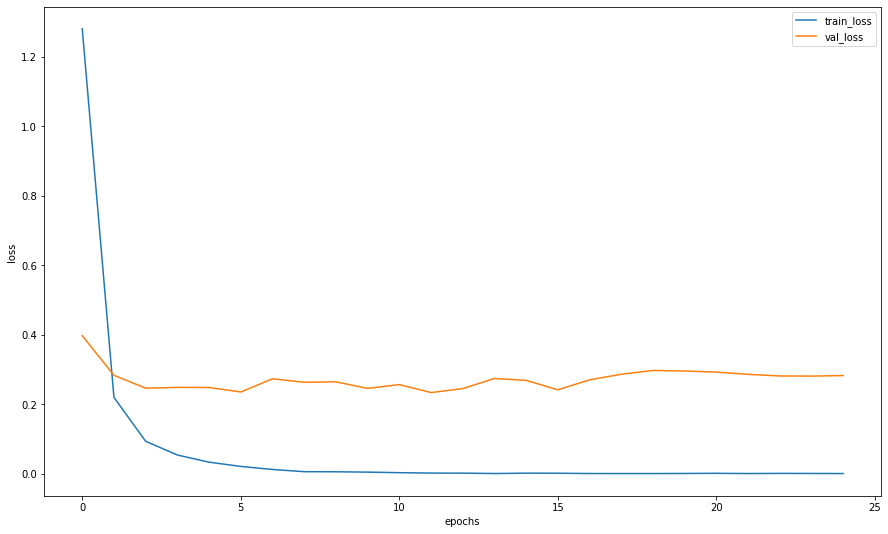

In [ ]:
loss, acc, val_loss, val_acc = zip(*history_vgg16)
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит. 
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(vgg16_bn_model, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(vgg16_bn_model, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [ ]:
y_pred == actual_labels

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode='test')

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

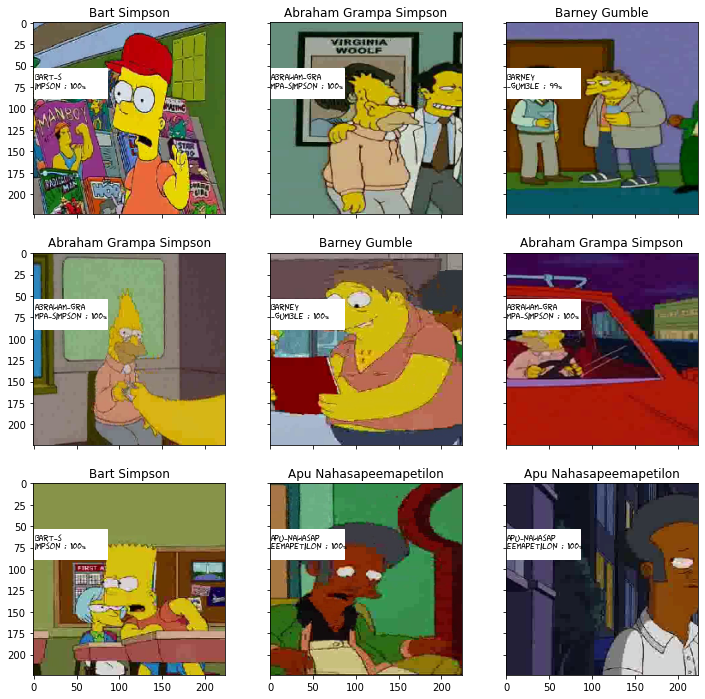

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(vgg16_bn_model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=128)
probs = predict(vgg16_bn_model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [ ]:
! ls 

In [ ]:
import pandas as pd
# my_submit = pd.read_csv("gdrive/My Drive/simpsons/data/labels.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
# TODO : сделайте сабмит (это важно, если Вы не справляетесь, но дошли до этой ячейки, то сообщите в чат и Вам помогут)

In [ ]:
my_submit.to_csv('gdrive/MyDrive/vgg16_bn_baseline_adamW.csv', index=False)

## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать. 

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову: 


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)
